# SVM: Best match of algorithms and rebalancing methods

In [ ]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

In [ ]:
df = pd.read_csv('/data_clinical_patient (1) (1).csv')

info = []

age = df['AGE']
sex = df['SEX']
stage = df['AJCC_PATHOLOGIC_TUMOR_STAGE']
race = df['RACE']
weight = df['WEIGHT']
# status = df['DSS_STATUS']
status = df['OS_STATUS']

c = 0
for i in range(len(df)):
    new_data = []
    if status.iloc[i] in ['0:LIVING', '1:DECEASED']: #['0:ALIVE OR DEAD TUMOR FREE', '1:DEAD WITH TUMOR']:
        if np.isnan(age.iloc[i]): # or np.isnan(weight.iloc[i]): 
            continue
        else:
            new_data.append(age.iloc[i])
        
        if not isinstance(sex.iloc[i], str): # or not isinstance(stage.iloc[i], str) or not isinstance(race.iloc[i], str):
            new_data.append(0.5)
        else:
            if sex.iloc[i] == 'Male':
                new_data.append(0)
            else:
                new_data.append(1)
                
        if not isinstance(stage.iloc[i], str):
            continue
        else:
            if 'IV' in stage.iloc[i]:
                new_data.append(4)
            elif 'III' in stage.iloc[i]:
                new_data.append(3)
            elif 'II' in stage.iloc[i]:
                new_data.append(2)
            elif 'I' in stage.iloc[i]:
                new_data.append(1)
                
        if not isinstance(race.iloc[i], str): # or not isinstance(race.iloc[i], str):
            continue
        else:
            if 'Black or African American' in race.iloc[i]:
                new_data += [1, 0, 0, 0]
            elif 'White' in race.iloc[i]:
                new_data += [0, 1, 0, 0]
            elif 'Asian' in race.iloc[i]:
                new_data += [0, 0, 1, 0]
            else:
                new_data += [0, 0, 0, 1]
                
        if np.isnan(weight.iloc[i]):
#             continue
            new_data.append(80.28)
        else:
            new_data.append(weight.iloc[i])
        
        if status.iloc[i] == '0:LIVING':
            new_data.append(0)
        else:
            new_data.append(1)

        info.append(new_data)
        

data = pd.DataFrame(info, columns=['age', 'sex', 'stage', 'isBlack', 'isWhite', 'isAsian', 'isNative', 'weight', 'isLive'])
data.head(3)

# lc = 0
# dc = 0
# for l in range(len(data['isLive'])):
#     if data['isLive'].iloc[l] == 0:
#         lc += 1
#     else:
#         dc += 1
# print(lc, dc)

,age,sex,stage,isBlack,isWhite,isAsian,isNative,weight,isLive
0,61.0,1,1,1,0,0,0,63.300,0
1,67.0,0,3,1,0,0,0,134.000,0
2,42.0,1,2,1,0,0,0,107.956,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'sex', 'stage', 'isBlack', 'isWhite', 'isAsian', 'isNative', 'weight']], data[['isLive']], test_size=0.2, shuffle=False)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
y_pred = model.predict(X_test)

print(len(X_train_std))

NameError: ignored

In [ ]:
def calculate_precision(pr, gt):
    TP = sum([p == g and g == 0 for p, g in zip(pr, gt)]) # are both alive
    TN = sum([p == g and g == 1 for p, g in zip(pr, gt)]) # are both dead
    FP = sum([p != g and g == 1 for p, g in zip(pr, gt)]) # predict as alive, but is dead
    FN = sum([p != g and g == 0 for p, g in zip(pr, gt)]) # predict as dead, but is alive
    
    
    return (TP)/(TP+FP)

def calculate_recall(pr, gt):
    TP = sum([p == g and g == 0 for p, g in zip(pr, gt)]) # are both alive
    TN = sum([p == g and g == 1 for p, g in zip(pr, gt)]) # are both dead
    FP = sum([p != g and g == 1 for p, g in zip(pr, gt)]) # predict as alive, but is dead
    FN = sum([p != g and g == 0 for p, g in zip(pr, gt)]) # predict as dead, but is alive
    
    
    return (TP)/(TP+FN)

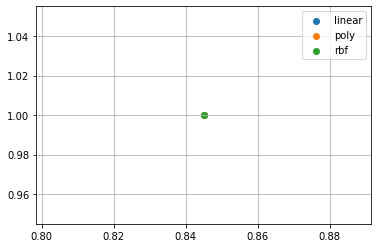

In [ ]:
from sklearn.svm import SVC

precision_list = []
recall_list = []

kernel_type_list = ['linear', 'poly', 'rbf']

fig, ax = plt.subplots()

for kernel_type in kernel_type_list:
    svm = SVC(kernel=kernel_type, probability=True)
    svm.fit(X_train_std,y_train['isLive'].values)
    pr = svm.predict(X_test_std)
    gt = y_test['isLive'].values
    
    precision, recall = calculate_precision(pr, gt), calculate_recall(pr, gt)    
    ax.scatter([precision], [recall], label=kernel_type)
    
ax.legend()
ax.grid(True)

plt.show()

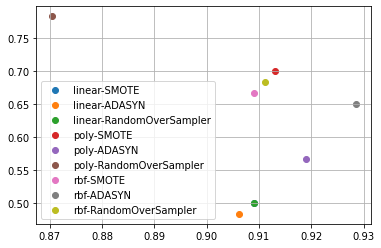

In [ ]:
from sklearn.svm import SVC
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
  
sampling_methods = {'SMOTE':SMOTE(sampling_strategy='minority', k_neighbors=5, random_state=42), 
                    'ADASYN':ADASYN(random_state=42),  
                    'RandomOverSampler':RandomOverSampler(sampling_strategy = 'minority', random_state=42)}

from imblearn.pipeline import make_pipeline

fig, ax = plt.subplots()

for kernel_type in kernel_type_list:
    for sampler_name, method in sampling_methods.items():
        model = make_pipeline(method, SVC(kernel=kernel_type, probability=True)) 

        svm = model
        svm.fit(X_train_std,y_train['isLive'].values)
        pr = svm.predict(X_test_std)
        gt = y_test['isLive'].values
        
        precision, recall = calculate_precision(pr, gt), calculate_recall(pr, gt)    
        ax.scatter([precision], [recall], label=kernel_type+'-'+sampler_name)
    
ax.legend()
ax.grid(True)

plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

confusionMatrix = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(confusionMatrix).plot()


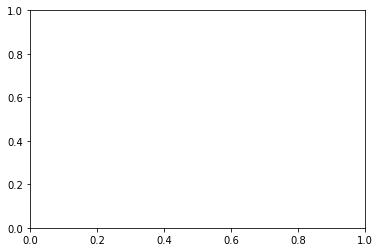

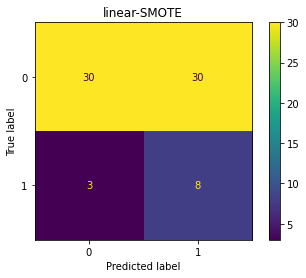

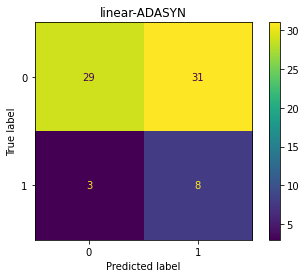

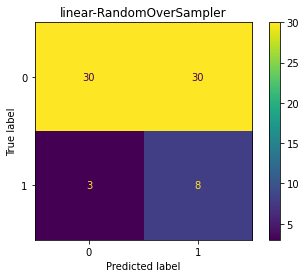

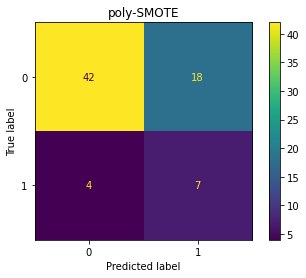

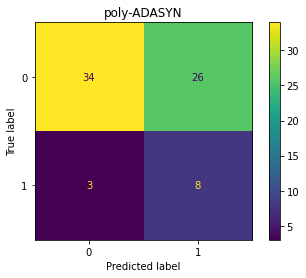

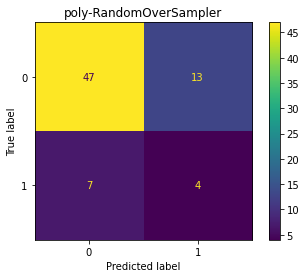

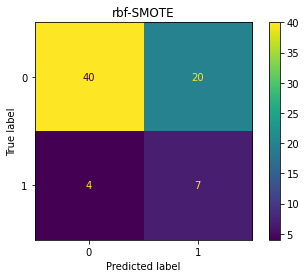

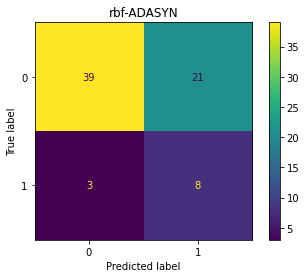

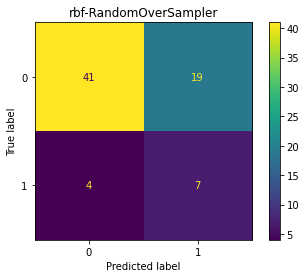

In [ ]:
from sklearn.svm import SVC
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay  
sampling_methods = {'SMOTE':SMOTE(sampling_strategy='minority', k_neighbors=5, random_state=42), 
                    'ADASYN':ADASYN(random_state=42),  
                    'RandomOverSampler':RandomOverSampler(sampling_strategy = 'minority', random_state=42)}

from imblearn.pipeline import make_pipeline

fig, ax = plt.subplots()

for kernel_type in kernel_type_list:
    for sampler_name, method in sampling_methods.items():
        model = make_pipeline(method, SVC(kernel=kernel_type, probability=True)) 

        svm = model
        svm.fit(X_train_std,y_train['isLive'].values)
        pr = svm.predict(X_test_std)
        gt = y_test['isLive'].values
        
        fig, ax = plt.subplots()
        ax.set_title(kernel_type+'-'+sampler_name)
        confusionMatrix = confusion_matrix(gt,pr) 
        Disp=ConfusionMatrixDisplay(confusionMatrix).plot(ax=ax)
        #Disp.ax.set_title(kernel_type+'-'+sampler_name)
       
    
